In [1]:
from utils import *
from helpers import *
import pandas as pd
from params import *
import os

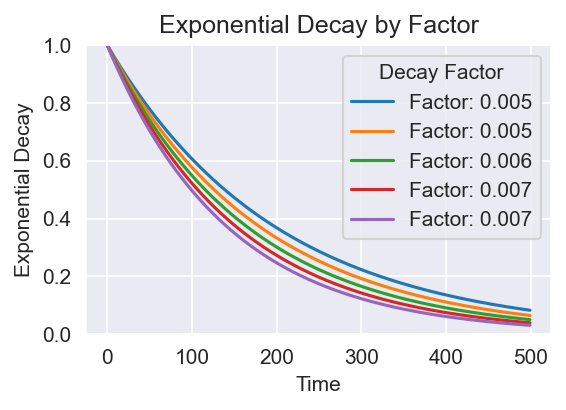

In [2]:
plot_exponential_decay_by_factor()

In [3]:
# from objects import RouteManager, EventManager
# route = RouteManager()
# event = EventManager()
# event.start_vehicles(route)
# route.load_all_pax()

### all scenarios

In [2]:
tstamp = '1024-133800'
delay_interval = 30*60 # 30 minutes
RESULTS_PATH = os.path.join(OUTPUT_FOLDER_PATH,'experiments_'+tstamp)
idle = pd.read_csv(os.path.join(RESULTS_PATH, 'idle.csv'))
pax = pd.read_csv(os.path.join(RESULTS_PATH, 'pax.csv'))
pax['bucket'] = pax['arrival_time'] // delay_interval
state = pd.read_csv(os.path.join(RESULTS_PATH, 'state.csv'))
trips = pd.read_csv(os.path.join(RESULTS_PATH, 'trips.csv'))
trips['delay'] = trips['arrival_time'] - trips['scheduled_time']
trips['bucket'] = trips['arrival_time'] // delay_interval
create_field_from_list_column(state, 4, 'delay')
create_field_from_list_column(state, 1, 'n_requests')
create_field_from_list_column(state, 0, 'denied', field_name='unweighted_rewards')
create_field_from_list_column(state, 1, 'early', field_name='unweighted_rewards')
create_field_from_list_column(state, 2, 'late', field_name='unweighted_rewards')

Text(0, 0.5, 'Average delay (s)')

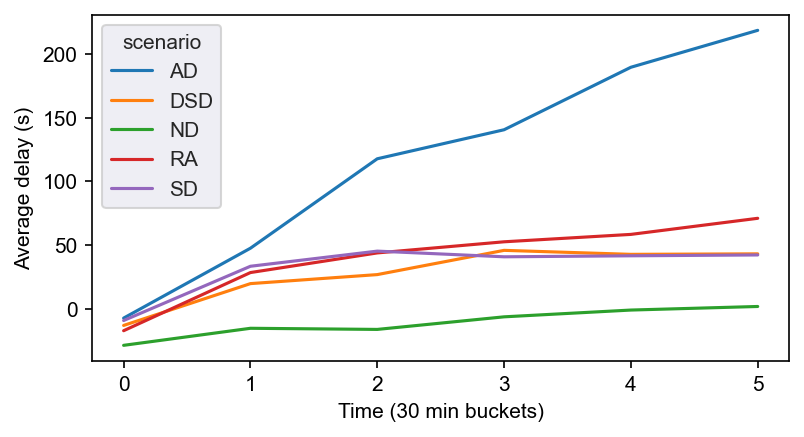

In [5]:
## get evolution of delay overtime by scenario with 30 minute buckets
tmp_trips = trips[['scenario', 'arrival_time', 'delay','bucket']].copy()
## remove maximum bucket
tmp_trips = tmp_trips[tmp_trips['bucket'] < MAX_TIME_HOURS*3600 // delay_interval]

fig, axs = plt.subplots(figsize=(6,3))
sns.set_style('darkgrid')
sns.lineplot(data=tmp_trips.groupby(['scenario', 'bucket']).agg({'delay': 'mean'}).reset_index(), x='bucket', y='delay', hue='scenario', ax=axs)
# tmp_trips.groupby(['scenario', 'bucket']).agg({'delay': 'mean'}).reset_index().pivot(index='bucket', columns='scenario', values='delay').plot(ax=axs)
axs.set_xlabel('Time (30 min buckets)')
axs.set_ylabel('Average delay (s)')

In [6]:
table, table_pcts = tabulate_improvements(state, idle, pax, trips, ON_TIME_BOUNDS, base_scenario='ND', flex_stops=FLEX_STOPS)

In [7]:
table

,idle_time,wait_time,headway_cv,load,n_denied_riders,fixed_ridership,flex_ridership,tot_ridership,n_trips,on_time_trips,avg_delay,n_deviations,avg_reward,on_time_rate,served_rate
scenario,,,,,,,,,,,,,,,
AD,4.54,340.0,0.403,3.31,350,6463,1168.0,7631,1063,667,117.0,863,-1.235,62.75,76.94
DSD,6.19,306.0,0.178,3.10,665,6745,839.0,7584,1075,922,30.0,489,-0.968,85.77,55.78
ND,13.04,305.0,0.135,2.56,1517,6602,NaN,6602,1086,1054,-10.0,0,-1.500,97.05,0.00
RA,7.84,319.0,0.272,2.95,918,6558,622.0,7180,1067,889,39.0,453,-1.262,83.32,40.39
SD,5.27,311.0,0.171,3.09,614,6715,892.0,7607,1070,924,36.0,628,-0.899,86.36,59.23


## finetune reward weights for trade-off type rewards

TODO: Pareto optimality between competing objectives??

In [8]:
def plot_avg_reward_per_scenario(rewards_per_scenario: pd.Series, axs):
    ## get barplot with figsize 4,3 for the avg_reward per scenario given table as dataset, after sorting by avg_reward
    rewards_per_scenario = rewards_per_scenario.sort_values()
    rewards_per_scenario.plot(kind='bar', ax=axs, y='avg_reward', color='skyblue')
    

def get_avg_weighted_rewards(rewards_per_step: pd.DataFrame, weights: list,
                             reward_fields: list):
    rewards = rewards_per_step.copy()
    rewards['total_w_reward'] = 0
    for i, field in enumerate(reward_fields):
        rewards['total_w_reward'] -= rewards[field] * weights[i]
    return rewards.groupby(['scenario'])['total_w_reward'].mean()

def plot_reward_weights_comparison(state: pd.DataFrame, weights_set: list):
    width_per_ax = 2.5
    height = 2.3
    n_weights = len(weights_set)
    fig, axs = plt.subplots(ncols=n_weights, figsize=(n_weights*width_per_ax, height))
    reward_fields = ['denied', 'early', 'late']
    tmp_state = state[['scenario'] + reward_fields].copy()
    for i, weights in enumerate(weights_set):
        tmp_rew = get_avg_weighted_rewards(tmp_state, weights, reward_fields)
        if n_weights > 1:
            plot_avg_reward_per_scenario(tmp_rew, axs[i])
            axs[i].set_title(f'Weights: {weights}')
        else:
            plot_avg_reward_per_scenario(tmp_rew, axs)
            axs.set_title(f'Weights: {weights}')


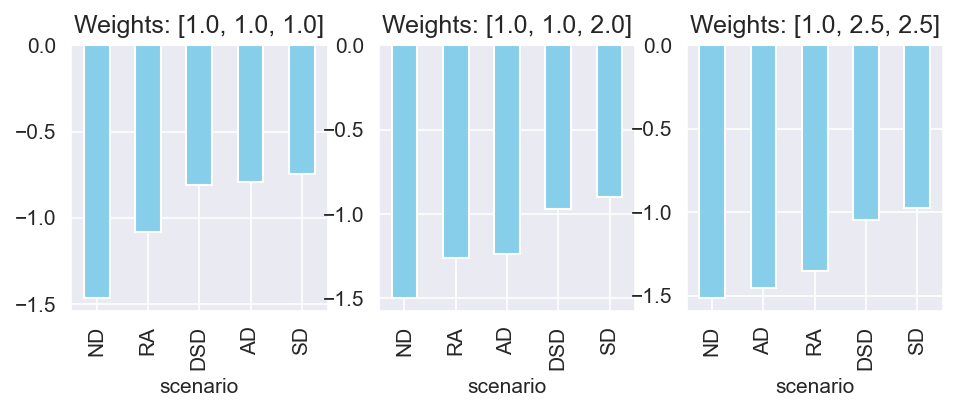

In [9]:
weights = [[1.0,1.0,1.0], [1.0,1.0,2.0], [1.0,2.5,2.5]]
plot_reward_weights_comparison(state, weights)

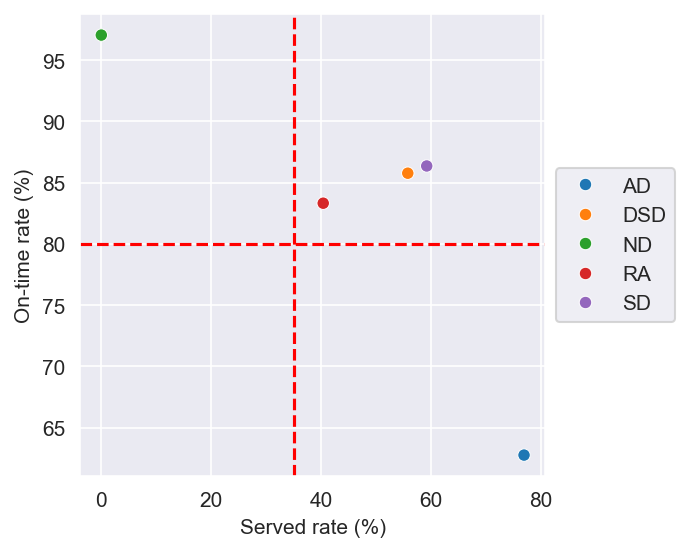

In [10]:
fig, axs = plt.subplots(figsize=(4,4))
## make background of axis dark
sns.set_style("darkgrid")
sns.scatterplot(data=table, x='served_rate', y='on_time_rate', hue='scenario', ax=axs)
axs.set_xlabel('Served rate (%)')
axs.set_ylabel('On-time rate (%)')
## set legend outside of plot
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))

x_line, y_line = 35, 80
axs.axvline(x=x_line, color='r', linestyle='--')
axs.axhline(y=y_line, color='r', linestyle='--')


<AxesSubplot: xlabel='idle_time', ylabel='Count'>

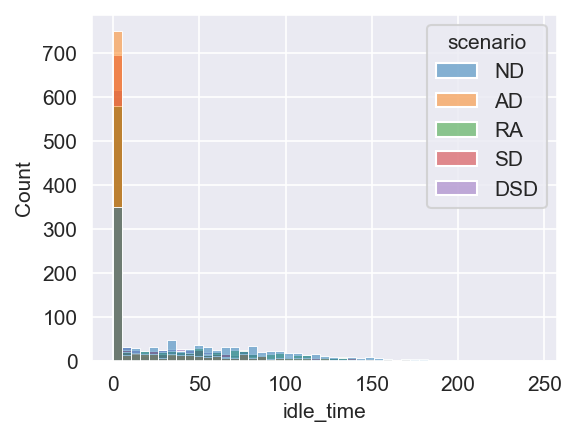

In [11]:
fig, axs = plt.subplots(figsize=(4,3))
sns.histplot(idle, x='idle_time', hue='scenario', common_norm=False)

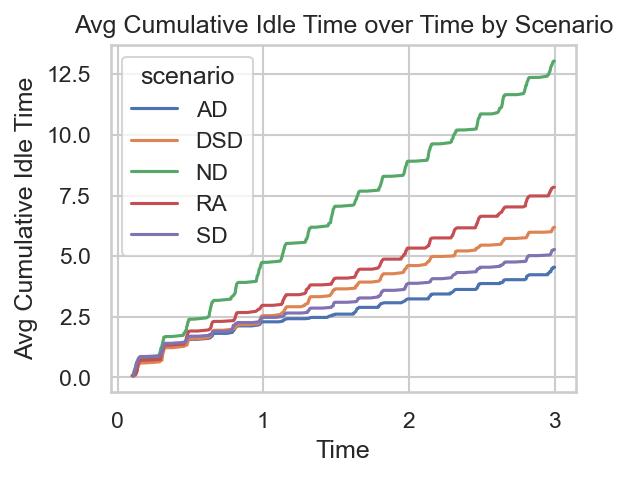

In [12]:
idle_for_plot = idle.copy()
idle_for_plot['idle_time'] = idle_for_plot['idle_time']/60/60
idle_for_plot['time'] = idle_for_plot['time']/60/60
plot_cumulative_idle_time(idle_for_plot)

## debugging

In [1]:
from objects import RouteManager, EventManager

route = RouteManager()
event = EventManager()
event.start_vehicles(route)
route.load_all_pax()

obs, reward, terminated, truncated, info = event.step(route, action=None)
# while not terminated:
#     obs, reward, terminated, truncated, info = event.step(route, action=True)

In [ ]:
event.timestamps[-1]

In [ ]:
pax.groupby(['origin', 'destination']).size().reset_index()

In [ ]:
for direction in ('in', 'out'):
    for s in route.stops[direction]:
        if s.active_pax:
            print([(direction, p.origin, p.destination, p.arrival_time) for p in s.active_pax])